In [1]:
from dataclasses import dataclass
from datetime import datetime, timedelta
import os
from pathlib import Path
from typing import List
pwd = Path(os.getcwd())

import pytz
import random
import sys
sys.path.append(str(pwd.parent))
sys.path.append(str(pwd.parent / "config"))

import warnings
warnings.simplefilter("ignore")

import networkx as nx
import numpy as np
from osmread import parse_file, Node, Way
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

from config import Config
from util import haversine
import matplotlib.pyplot as plt
import matplotlib as mpl

config = Config.load()

In [2]:
time_step = int(config.TIMESTEP) / 1e9 / 60

In [3]:
import glob
import json
adj_data_path = glob.glob(f"../data/{config.DATA_SIZE}/*Neighbor.csv")[0]
size = len(pd.read_csv(adj_data_path, header=None))
A = np.zeros((size,size))
with open(adj_data_path) as f:
    for i in range(size):
        tmp = f.readline().replace('""','"').replace('"{','{').replace('}"','}').rstrip()
        for info_str in tmp.split("},"):
            if info_str[-1] != "}":
                info_str += "}"
            info = json.loads(info_str)
            if info["distance"] < time_step:
                A[i][info["area_id"]] = 1
                A[info["area_id"]][i] = 1

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self, num_node_features: int, num_nodes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, num_nodes)
        self.conv2 = GCNConv(num_nodes, num_nodes)
        self.fc = torch.nn.Linear(num_nodes*num_nodes, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = torch.flatten(x)
        return self.fc(x)
        

In [5]:
src_list = []
dst_list = []
for i in range(size):
    for j in range(size):
        if A[i][j] == 1:
            src_list.append(i)
            dst_list.append(j)
edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)

# create training data

In [6]:
node_data_df = pd.read_csv(f"../data/{config.DATA_SIZE}/NodeConnection.csv")[["NodeID", "Latitude", "Longitude"]].drop_duplicates()

In [7]:
order_df = pd.read_csv(f"../data/yellow_tripdata_2015-06.csv")

USE_COLUMNS = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
]
RENAME_DICT = {
    "tpep_pickup_datetime": "Start_time",
    "tpep_dropoff_datetime": "End_time",
    "pickup_longitude": "PointS_Longitude",
    "pickup_latitude": "PointS_Latitude",
    "dropoff_longitude": "PointE_Longitude",
    "dropoff_latitude": "PointE_Latitude",
}

rename_order_df = order_df[USE_COLUMNS].rename(columns=RENAME_DICT).sort_values("Start_time").reset_index(drop=True)

# NewYorkエリア外のレコードを除去する.
rename_order_without_outlier_df = rename_order_df[
    (rename_order_df["PointS_Longitude"] > config.LOCAL_REGION_BOUND.west_bound)
    & (rename_order_df["PointS_Longitude"] < config.LOCAL_REGION_BOUND.east_bound)
    & (rename_order_df["PointE_Longitude"] > config.LOCAL_REGION_BOUND.west_bound)
    & (rename_order_df["PointE_Longitude"] < config.LOCAL_REGION_BOUND.east_bound)
    & (rename_order_df["PointS_Latitude"] > config.LOCAL_REGION_BOUND.south_bound)
    & (rename_order_df["PointS_Latitude"] < config.LOCAL_REGION_BOUND.north_bound)
    & (rename_order_df["PointE_Latitude"] > config.LOCAL_REGION_BOUND.south_bound)
    & (rename_order_df["PointE_Latitude"] < config.LOCAL_REGION_BOUND.north_bound)
]

In [8]:
nn = NearestNeighbors(algorithm='ball_tree')
nn.fit(node_data_df[["Longitude", "Latitude"]].values)

node_id_list = node_data_df["NodeID"].values.tolist()

_, start_indices = nn.kneighbors(
    rename_order_without_outlier_df[["PointS_Longitude", "PointS_Latitude"]], n_neighbors=1)
rename_order_without_outlier_df["NodeS"] = [node_id_list[i[0]] for i in start_indices]

In [9]:
node_to_grid_df = pd.read_csv(f"../data/{config.DATA_SIZE}/(-74.0088, -73.9778, 40.7111, 40.7471)53TransportationClusteringCluster.csv")
node_to_grid_info = {}
for node_id, grid_id in zip(node_to_grid_df["NodeID"], node_to_grid_df["GridID"]):
    node_to_grid_info[node_id] = grid_id

In [10]:
rename_order_without_outlier_df.head()

,Start_time,End_time,PointS_Longitude,PointS_Latitude,PointE_Longitude,PointE_Latitude,NodeS
30,2015-06-01 00:00:08,2015-06-01 00:36:25,-73.987793,40.732361,-73.987793,40.732361,8309479665
34,2015-06-01 00:00:09,2015-06-01 00:01:52,-74.005989,40.735191,-73.999718,40.743622,8307463843
35,2015-06-01 00:00:09,2015-06-01 00:02:49,-73.988045,40.731632,-73.980858,40.730545,8309479665
45,2015-06-01 00:00:14,2015-06-01 00:08:42,-73.982330,40.744888,-74.003281,40.735100,8119462495
54,2015-06-01 00:00:16,2015-06-01 00:08:59,-73.991737,40.729820,-73.984352,40.716393,5706569384


In [11]:
rename_order_without_outlier_df["GridID"] = rename_order_without_outlier_df["NodeS"].map(node_to_grid_info)
rename_order_without_outlier_df.head()

,Start_time,End_time,PointS_Longitude,PointS_Latitude,PointE_Longitude,PointE_Latitude,NodeS,GridID
30,2015-06-01 00:00:08,2015-06-01 00:36:25,-73.987793,40.732361,-73.987793,40.732361,8309479665,37
34,2015-06-01 00:00:09,2015-06-01 00:01:52,-74.005989,40.735191,-73.999718,40.743622,8307463843,40
35,2015-06-01 00:00:09,2015-06-01 00:02:49,-73.988045,40.731632,-73.980858,40.730545,8309479665,37
45,2015-06-01 00:00:14,2015-06-01 00:08:42,-73.982330,40.744888,-74.003281,40.735100,8119462495,52
54,2015-06-01 00:00:16,2015-06-01 00:08:59,-73.991737,40.729820,-73.984352,40.716393,5706569384,30


In [12]:
def newyork_datetime_to_utc(datetime_str: str) -> int:
    eastern = pytz.timezone('US/Eastern')
    date = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
    date.astimezone(eastern)
    return int(date.timestamp())

rename_order_without_outlier_df["Start_datetime"] = rename_order_without_outlier_df["Start_time"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)
rename_order_without_outlier_df["month"] = rename_order_without_outlier_df["Start_datetime"].apply(lambda x: x.month)
rename_order_without_outlier_df["day"] = rename_order_without_outlier_df["Start_datetime"].apply(lambda x: x.day)
rename_order_without_outlier_df["hour"] = rename_order_without_outlier_df["Start_datetime"].apply(lambda x: x.hour)
rename_order_without_outlier_df["minute"] = rename_order_without_outlier_df["Start_datetime"].apply(lambda x: (((x.minute // 10)) % 6) * 10 )

In [13]:
months = [6]
days = list(range(1,32))
hours = list(range(0,24))
minutes = list(range(0,60, 10))

In [14]:
from sklearn.preprocessing import StandardScaler

cols = ["GridID", "month", "day", "hour", "minute"]
raw_feature_df = rename_order_without_outlier_df[cols]

date_feature = []
for grid_id in sorted(raw_feature_df["GridID"].unique()):
    tmp1 = raw_feature_df[(raw_feature_df["GridID"]==grid_id)]
    for month in months:
        tmp2 = tmp1[(tmp1["month"]==month)]
        before = 0
        for day in days:
            tmp3 = tmp2[(tmp2["day"]==day)]
            for hour in hours:
                tmp4 = tmp3[(tmp3["hour"]==hour)]
                for minute in minutes:
                    tmp5 = tmp4[(tmp4["minute"]==minute)]
                    date_feature.append([grid_id, month, day, hour, minute, len(tmp5), before])
                    before = len(tmp5)
full_feature_df = pd.DataFrame(date_feature, columns=["GridID", "month", "day", "hour", "minute", "target", "before"])

In [16]:
feature_columns = ["GridID", "month", "day", "hour", "minute", "before"]

train_df = full_feature_df[full_feature_df["day"]<=23].reset_index()
test_df = full_feature_df[full_feature_df["day"]>=24].reset_index()

ss = StandardScaler()
train_features = ss.fit_transform(train_df[feature_columns].values)
test_features = ss.transform(test_df[feature_columns].values)

train_df.rename(columns={col: "raw_" + col for col in feature_columns}, inplace=True)
test_df.rename(columns={col: "raw_" + col for col in feature_columns}, inplace=True)

scaled_train_feature = pd.DataFrame(train_features, columns=feature_columns)
scaled_test_feature = pd.DataFrame(test_features, columns=feature_columns)

train_feature_df = pd.concat([train_df, scaled_train_feature], axis=1)
test_feature_df = pd.concat([test_df, scaled_test_feature], axis=1)

In [17]:
class Data:
    feature: list
    target: list

class DatasetIterator:
    def __init__(self, features, targets, batch_size=64):
        self.__batch_size = batch_size
        self.__features = features
        self.__targets = targets
        self.__i = 0
        self.__numbers = 0
        self.__random_index = list(range(len(self.__features)))
        random.shuffle(self.__random_index)

    @property
    def num_batch(self):
        return len(self.__features) // self.__batch_size

    def __iter__(self):
        return self

    def __next__(self):
        if self.__i == self.num_batch:
            idx_list = self.__random_index[self.__i * self.__batch_size:]
            self.__i += 1
            return Data(
                feature=self.__features[idx_list],
                target=self.__targets[idx_list],
            )
        if self.__i == (self.num_batch + 1):
            raise StopIteration()
        idx_list = self.__random_index[self.__i * self.__batch_size:(self.__i + 1) * self.__batch_size]
        self.__i += 1
        return Data(
                feature=self.__features[idx_list],
                target=self.__targets[idx_list],
            )
    

class Dataset:
    def __init__(self, batch_size=64):
        self.__batch_size = batch_size
        self.__features = []
        self.__targets = []

    def add_feature(self, feature):
        self.__features.append(feature)

    def add_target(self, target):
        self.__targets.append(target)

    @property
    def num_batch(self):
        return len(self.__features) // self.__batch_size
        
    def __iter__(self):
        return DatasetIterator(np.array(self.__features), np.array(self.__targets.copy()), self.__batch_size)

In [19]:
from torch_geometric.data import Data

train_dataset = Dataset()

for month in months:
    for day in list(range(1,24)):
        for hour in hours:
            for minute in minutes:
                train_dataset.add_feature(
                    train_feature_df[
                        (train_feature_df["raw_month"]==month)
                        & (train_feature_df["raw_day"]==day)
                        & (train_feature_df["raw_hour"]==hour)
                        & (train_feature_df["raw_minute"]==minute)
                    ][feature_columns].values
                )
                train_dataset.add_target(
                    train_feature_df[
                        (train_feature_df["raw_month"]==month)
                        & (train_feature_df["raw_day"]==day)
                        & (train_feature_df["raw_hour"]==hour)
                        & (train_feature_df["raw_minute"]==minute)
                    ]["target"].values
                )

test_dataset = Dataset()

for month in months:
    for day in list(range(24,31)):
        for hour in hours:
            for minute in minutes:
                test_dataset.add_feature(
                    test_feature_df[
                        (test_feature_df["raw_month"]==month)
                        & (test_feature_df["raw_day"]==day)
                        & (test_feature_df["raw_hour"]==hour)
                        & (test_feature_df["raw_minute"]==minute)
                    ][feature_columns].values
                )
                test_dataset.add_target(
                    test_feature_df[
                        (test_feature_df["raw_month"]==month)
                        & (test_feature_df["raw_day"]==day)
                        & (test_feature_df["raw_hour"]==hour)
                        & (test_feature_df["raw_minute"]==minute)
                    ]["target"].values
                )

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(num_node_features=len(feature_columns), num_nodes=size).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

net.train()
losses = []
for _ in range(10):
    for batch in train_dataset:
        targets = None
        preds = None
        optimizer.zero_grad()
        for feature, target in zip(batch.feature, batch.target):
            feature_tensor = torch.tensor(feature, dtype=torch.float)
            y_tensor = torch.tensor(target, dtype=torch.float)
            data = Data(x=feature_tensor, edge_index=edge_index, y=y_tensor)
            pred = net(data)
            if preds is None:
                targets = y_tensor
                preds = pred
            else:
                targets = torch.concat([targets, y_tensor])
                preds = torch.concat([preds, pred])
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())

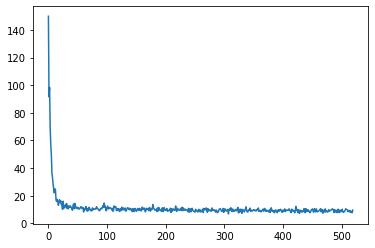

In [22]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses))), losses)

In [30]:
net.eval()

for batch in test_dataset:
    targets = None
    preds = None
    optimizer.zero_grad()
    for feature, target in zip(batch.feature, batch.target):
        feature_tensor = torch.tensor(feature, dtype=torch.float)
        y_tensor = torch.tensor(target, dtype=torch.float)
        data = Data(x=feature_tensor, edge_index=edge_index, y=y_tensor)
        pred = net(data).detach()
        if preds is None:
            targets = y_tensor
            preds = pred
        else:
            targets = torch.concat([targets, y_tensor])
            preds = torch.concat([preds, pred])

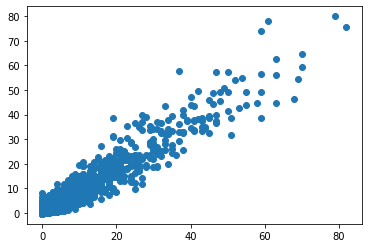

In [31]:
plt.scatter(targets.numpy(), preds.numpy())

tensor([ 5.4854,  0.5875,  0.3699,  ...,  3.7447, 28.4466, 10.1963],
       grad_fn=<CatBackward0>)